In [1]:
import numpy as np
from sklearn.externals import joblib
import copy
import random
import math
import matplotlib as mp
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.base import clone
from sklearn import metrics
from __future__ import unicode_literals

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [3]:
mp.rcParams.update({'font.size': 16})

In [4]:
datadict = joblib.load("Two_Port_Standard_Dictionary_Cleaned_Interpolated.pkl")

In [5]:
num_fake_points = 15000
magS11_deviation = 0.003
magS21_deviation = 0.0001
magS22_deviation = 0.003
frequency_range = np.linspace(2,18,50)

In [6]:
magS11_points = []
magS21_points = []
magS22_points = []
for i in range(num_fake_points):
    new_dataset = copy.deepcopy(datadict['CTN210']['System 2,7'][random.choice(datadict['CTN210']['System 2,7'].keys())])
    new_dataset["magS11"] += np.random.normal(0,magS11_deviation,50)
    new_dataset["magS21"] += np.random.normal(0,magS21_deviation,50)
    new_dataset["magS22"] += np.random.normal(0,magS22_deviation,50)
    magS11_points.append(new_dataset["magS11"].tolist())
    magS21_points.append(new_dataset["magS21"].tolist())
    magS22_points.append(new_dataset["magS22"].tolist())
magS11_arr = np.array(magS11_points)
magS21_arr = np.array(magS21_points)
magS22_arr = np.array(magS22_points)

In [7]:
names = ["Gaussian Naive Bayes",
         "Decision Tree",
         "Random Forest",
         "Quadratic Discriminant Analysis",
         "Voting",
         "Random Forest with Grid Search"]
classifiers = [GaussianNB(),
               DecisionTreeClassifier(),
               RandomForestClassifier(),
               QuadraticDiscriminantAnalysis(),
               VotingClassifier(estimators=[
                   ('gnb',GaussianNB()),
                   ('rf',RandomForestClassifier()),
                   ('dt',DecisionTreeClassifier()),
                   ('qda',QuadraticDiscriminantAnalysis())
               ],voting="soft")]

In [8]:
def get_trained_classifier(randomness_amplitude,untrained_classifier):
    incorrect_magS21_data = copy.deepcopy(magS21_arr)
    for i in range(len(incorrect_magS21_data)):
        incorrect_magS21_data[i] = (incorrect_magS21_data[i] + np.random.normal(0,randomness_amplitude,50))
    #Making training and test data
    S21_training_data = []
    S21_training_data.extend(incorrect_magS21_data.tolist())
    S21_training_data.extend(magS21_arr.tolist())
    S21_training_data_arr = np.array(S21_training_data)
    targets = ["Bad","Good"]
    S21_target_arr = np.repeat(targets,len(magS21_arr))
    S21_training_data_arr,S21_target_arr = shuffle(S21_training_data_arr,S21_target_arr, random_state=0)
    #Cloning and Training Classifier
    clf = clone(untrained_classifier)
    clf.fit(S21_training_data_arr,S21_target_arr)
    return clf

In [9]:
def get_test_data_accuracy(randomness_amplitude,trained_classifier):
    test_data = copy.deepcopy(magS21_arr)
    expected = []
    for i in range(len(test_data)):
        test_data[i] = test_data[i] + np.random.normal(0,randomness_amplitude,50)
        over_good_data_amplitude = False
        for valueindex in range(len(test_data[i])):
            if test_data[i][valueindex] > magS21_arr[i][valueindex] + magS21_deviation or test_data[i][valueindex] < magS21_arr[i][valueindex]-magS21_deviation:
                over_good_data_amplitude=True
        if over_good_data_amplitude:
            expected.append("Bad")
        else:
            expected.append("Good")
    predicted = trained_classifier.predict(test_data)
    num_correct_points = 0
    for index in range(len(predicted)):
        if predicted[index] == expected[index]:
            num_correct_points += 1
    return (num_correct_points/float(len(expected)))*100.0

In [10]:
randomness_amp = 0.001
num_test_amplitudes = 50
test_amplitude_min = 0
test_amplitude_max = 0.0015

In [11]:
results_dict = {}
test_amplitudes = np.linspace(test_amplitude_min,test_amplitude_max,num_test_amplitudes)
for index in range(len(classifiers)):
    trained_classifier = get_trained_classifier(randomness_amp,classifiers[index])
    results_dict[names[index]] = []
    for amp in test_amplitudes:
        test_data_accuracy = get_test_data_accuracy(amp,trained_classifier)
        results_dict[names[index]].append(test_data_accuracy)
    print "Finished a Classifier!"
print "Done!"

Finished a Classifier!
Finished a Classifier!
Finished a Classifier!
Finished a Classifier!
Finished a Classifier!
Done!


In [12]:
print results_dict["Random Forest"]

[99.99333333333334, 94.44, 0.6933333333333334, 1.0666666666666667, 4.966666666666667, 15.686666666666666, 33.27333333333333, 52.87333333333334, 70.11333333333334, 82.44666666666667, 90.37333333333333, 94.67333333333333, 97.44666666666667, 98.57333333333334, 99.33333333333333, 99.61333333333333, 99.8, 99.92666666666666, 99.96000000000001, 99.97333333333333, 99.98, 99.98, 99.98, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


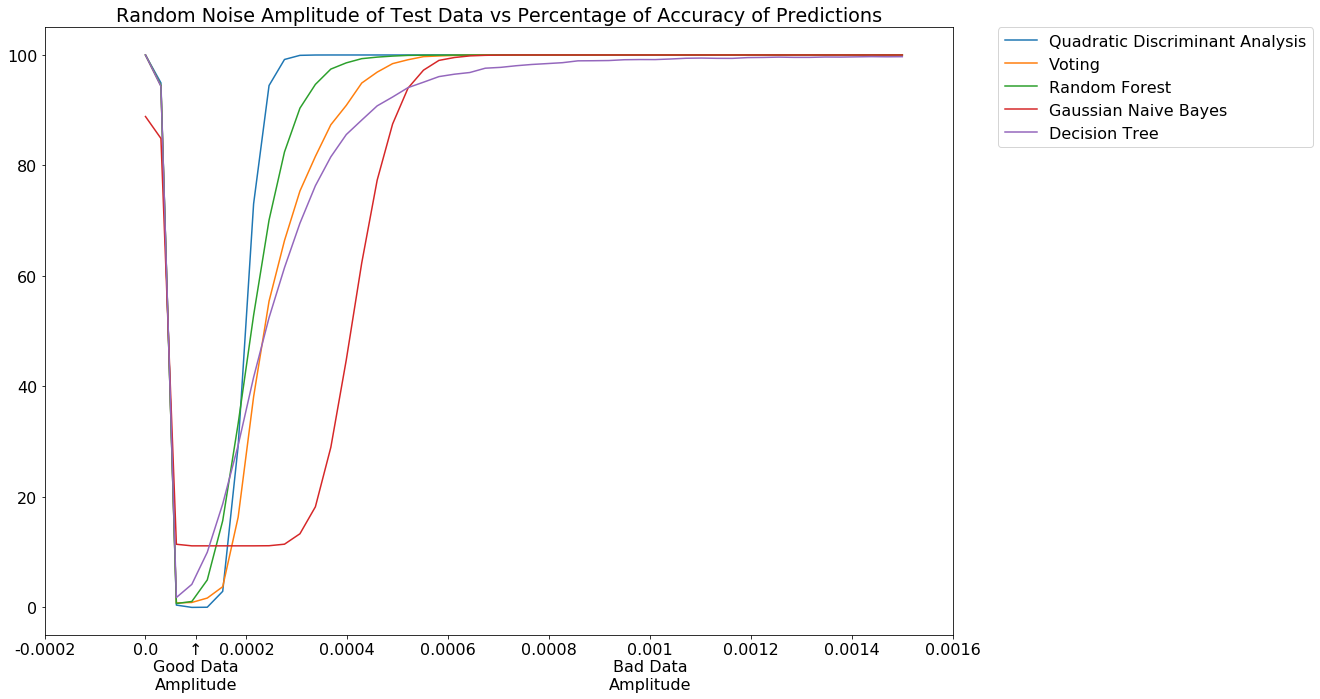

In [13]:
label_handles = []
plt.figure(figsize=(14,10))
for key in results_dict.keys():
    label_handles.extend(plt.plot(test_amplitudes,results_dict[key],label=key))
ax = plt.gca()
ax.set_xticks(list(ax.get_xticks()) + [magS21_deviation])
labels = ax.get_xticks()
labels2 = [str(x) for x in labels]
labels2[10] = "↑\nGood Data\nAmplitude"
labels2[6] = "0.001\nBad Data\nAmplitude"
ax.set_xticklabels(labels2)
plt.legend(handles=label_handles,bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title("Random Noise Amplitude of Test Data vs Percentage of Accuracy of Predictions")
plt.tight_layout()
plt.show()

In [14]:
def get_test_data_accuracy_and_data(randomness_amplitude,trained_classifier):
    test_data = copy.deepcopy(magS21_arr)
    expected = []
    for i in range(len(test_data)):
        test_data[i] = test_data[i] + np.random.normal(0,randomness_amplitude,50)
        over_good_data_amplitude = False
        for valueindex in range(len(test_data[i])):
            if test_data[i][valueindex] > magS21_arr[i][valueindex] + magS21_deviation or test_data[i][valueindex] < magS21_arr[i][valueindex]-magS21_deviation:
                over_good_data_amplitude=True
        if over_good_data_amplitude:
            expected.append("Bad")
        else:
            expected.append("Good")
    predicted = trained_classifier.predict(test_data)
    num_correct_points = 0
    for index in range(len(predicted)):
        if predicted[index] == expected[index]:
            num_correct_points += 1
    actual_experimental_value = datadict['CTN210']['System 2,7'][datadict['CTN210']['System 2,7'].keys()[0]]
    return ((num_correct_points/float(len(expected))),
            actual_experimental_value["magS21"]+randomness_amplitude,
            actual_experimental_value["magS21"]-randomness_amplitude)

In [15]:
results_dict_with_data = {}
for index in range(len(classifiers)):
    trained_classifier = get_trained_classifier(randomness_amp,classifiers[index])
    results_dict_with_data[names[index]] = []
    for amp in test_amplitudes:
        test_results = get_test_data_accuracy_and_data(amp,trained_classifier)
        results_dict_with_data[names[index]].append(test_results)
    print "Finished Classifier!"
print "Done!"

Finished Classifier!
Finished Classifier!
Finished Classifier!
Finished Classifier!
Finished Classifier!
Done!


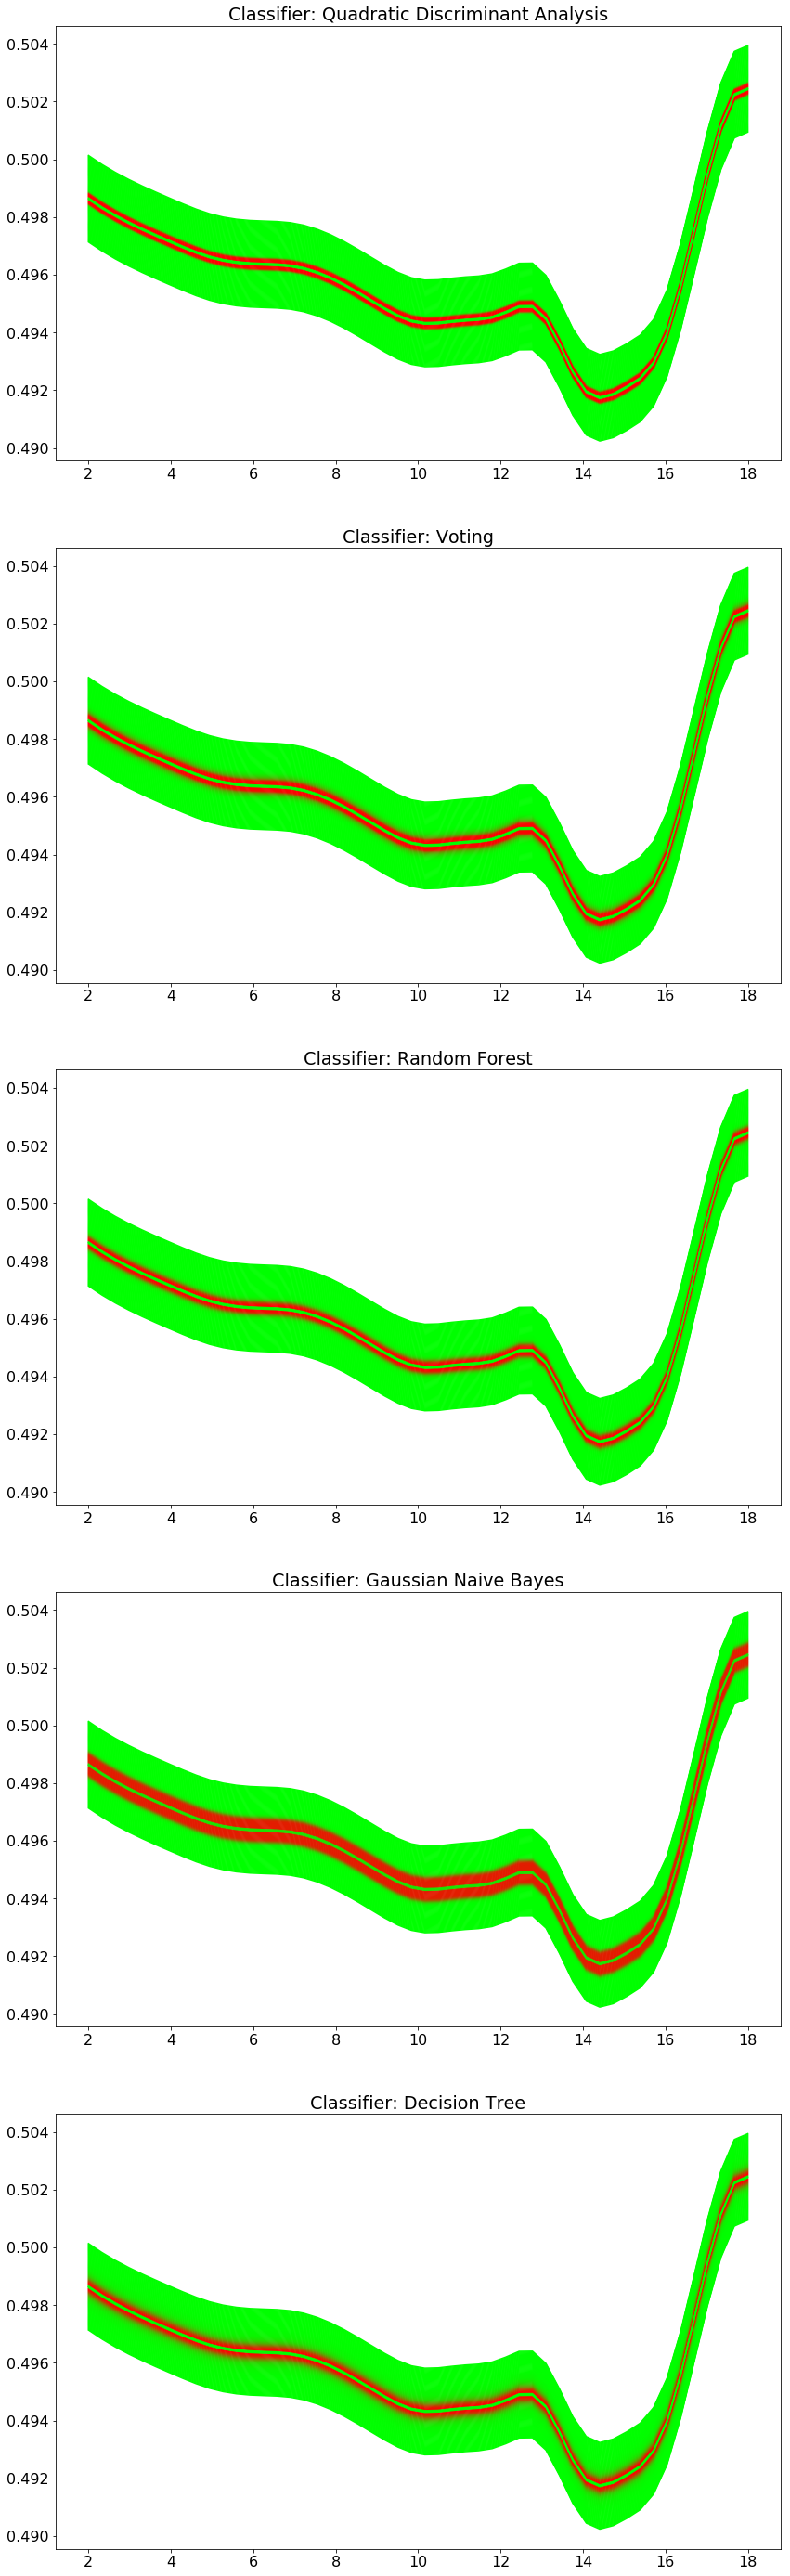

In [16]:
plt.figure(figsize=(14,50))
for index, key in enumerate(results_dict_with_data.keys()):
    plt.subplot(len(results_dict_with_data.keys()),1,index+1)
    plt.title("Classifier: " + key)
    for z_value,linedata in enumerate(reversed(results_dict_with_data[key])):
        plt.plot(frequency_range,linedata[1],color=(1-linedata[0],linedata[0],0),zorder=z_value)
        plt.plot(frequency_range,linedata[2],color=(1-linedata[0],linedata[0],0),zorder=z_value)
plt.show()